In [15]:
import geopandas as gpd
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from modules.Base import BaseModule

import warnings
warnings.filterwarnings("ignore")

In [19]:
class Streets(BaseModule):
    def __init__(self) -> None:
        super().__init__()
        self.nodes_cols = []
        self.edges_cols = []
        pass

    def load_data(self):
        self.scenarios = []
        [
            self.scenarios.append({
                    # 'nodes': gpd.read_file(node_file).to_crs(self.default_crs),
                    # 'edges': gpd.read_file(edge_file).to_crs(self.default_crs)
                    'nodes': gpd.read_parquet(node_file),
                    'edges': gpd.read_parquet(edge_file)
            })
            for node_file, edge_file in zip(
                glob('/app/assets/streets/*/nodes.parquet'),
                glob('/app/assets/streets/*/edges.parquet')
                )
        ]
        # Assume that the baseline is in index 0
        self.current_scenario = self.scenarios[0]
        pass

    def update_plate_area(self, plate_id, scenario_id):
        # Change the nodes and edges within the area into plate

        current_nodes = self.current_scenario['nodes']
        current_edges = self.current_scenario['edges']

        update_nodes = self.scenarios[scenario_id]['nodes']
        update_edges = self.scenarios[scenario_id]['edges']

        mask_current_nodes = current_nodes['plate_id'] != plate_id
        mask_current_edges = current_edges['plate_id'] != plate_id

        mask_update_nodes = update_nodes['plate_id'] == plate_id
        mask_update_edges = update_edges['plate_id'] == plate_id

        nodes_updated = pd.concat([
            current_nodes[mask_current_nodes],
            update_nodes[mask_update_nodes]
            ])
        
        edges_updated = pd.concat([
            current_edges[mask_current_edges],
            update_edges[mask_update_edges]
            ])

        # print(nodes_updated.head(3))
        # print(edges_updated.head(3))

        self.current_scenario = {
            'nodes': gpd.GeoDataFrame(data=nodes_updated.drop(columns=['geometry']), geometry=nodes_updated['geometry']),
            'edges': gpd.GeoDataFrame(data=edges_updated.drop(columns=['geometry']), geometry=edges_updated['geometry']),
        }
        pass

In [20]:
st = Streets()
st.load_data()

<Axes: >

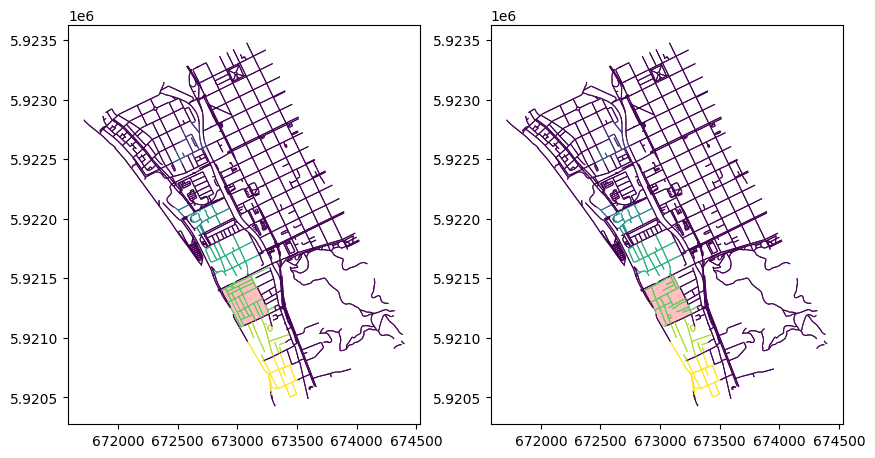

In [27]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
gpd.sjoin(st.current_scenario['edges'], st.area_scope).plot(column='plate_id', linewidth=0.75, ax=ax[0])
st.plates['6'].plot(ax=ax[0], alpha=0.25, color='red')
st.update_plate_area(plate_id=6, scenario_id=0)
gpd.sjoin(st.current_scenario['edges'], st.area_scope).plot(column='plate_id', linewidth=0.75, ax=ax[1])
st.plates['6'].plot(ax=ax[1], alpha=0.25, color='red')

In [11]:
st.update_plate_area(plate_id=6, scenario_id=1)

       osmid          y          x  street_cou   highway  plate_id  \
0  267252253 -36.826699 -73.040321         2.0      None         0   
1  267252256 -36.826739 -73.040342         4.0  crossing         0   
2  267252355 -36.826220 -73.037381         4.0      None         0   

                         geometry  lat  lon  id  
0  POINT (674769.156 5922560.301)  NaN  NaN NaN  
1  POINT (674767.131 5922555.936)  NaN  NaN NaN  
2  POINT (675032.401 5922608.020)  NaN  NaN NaN  
           u           v  key      osmid  oneway lanes  \
0  267252253   267252256    0  368010828     0.0     2   
1  267252253  3718767746    0  368010828     0.0     2   
2  267252256  8355196537    0  367537909     0.0     2   

                           name      highway  reversed  length  ...  area  \
0                    Plaza Perú    secondary       0.0   4.818  ...  None   
1                    Plaza Perú    secondary       1.0   3.905  ...  None   
2  Diagonal Pedro Aguirre Cerda  residential       0.0 